In [125]:
import networkx as nx

In [126]:
# Dessine un graph à partir d'une liste d'arrête.
def print_graph(edges, directed = False):
    lgt = len(edges)
    i = 1
    # On trouve d'abord tous les différents sommets
    vertices = [edges[0][0]]
    while (i < lgt):
        if (edges[i][0] != vertices[0]):
            vertices.insert(0, edges[i][0])
        i += 1
    
    graph = nx.MultiGraph()
    if (directed):
        graph = nx.MultiDiGraph()
    
    graph.add_nodes_from(vertices)
    graph.add_edges_from(edges)
    
    nx.draw(graph, with_labels=True)

# Drone

In [127]:
def find_cycle(u, E, cycle): 
  for (a, b) in E:
    if a == u:
        E.remove((a, b))
        find_cycle(b, E, cycle)
    elif b == u:
        E.remove((a, b))
        find_cycle(a, E, cycle)
  cycle.insert(0, u)
    
def find_eulerian_cycle(graph):
    cycle = []
    find_cycle(graph[0][0], graph, cycle)
    return cycle
    
    

[1, 2, 3, 4, 3, 1]


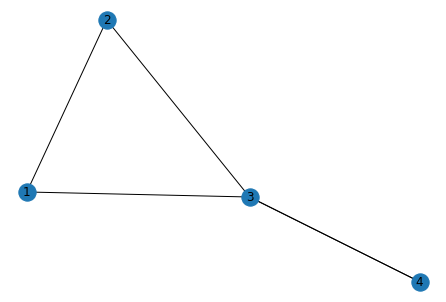

In [128]:
edges = [(1, 2), (2, 3), (3, 1), (3, 4), (4, 3)]
print_graph(edges) # Attention aux arêtes en double
print(find_eulerian_cycle(edges))

# Déblaiement

### Obtenir un graphe eulérien

#### Calcul des degrées de chaque sommet

In [129]:
def create_dict_edges(edges, lgt):
    res = {}
    i = 0

    while (i < lgt):
        cur_v = edges[i][0]
        begin = i
        while (i < lgt and cur_v == edges[i][0]):
            i += 1
        # Indice du début des arrêtes partant du sommet, nombre des dites arrêtes, degrés entrants en négatif (servira ensuite à eulerizer)
        res[cur_v] = [begin, i - begin, (i - begin)]
    
    i = 0
    # On ajoute tous les degrées sortant à chacun des noeuds correspondant
    while (i < lgt):
        res[edges[i][1]][2] -= 1
        i += 1

    # Pour chaque sommet, on a donc un nombre négatif s'il y a plus de degrés entrants (donc origines pour de nouvelles arrêtes)
    # et inversement : un nombre positif s'il y a plus de degrés sortants (donc destinations pour de nouvelles arrêtes)
    return res

#### Calcul de plus court chemin

In [130]:
import math

def min(todo, dist):
    # Trouve le sommet avec la distance la plus courte dans la liste todo.
    minval = math.inf
    min = None
    for i in todo:
        if (dist[i][0] < minval):
            minval = dist[i][0]
            min = i
    return min


def find_weight(frm, to, edges, dict):
    # Trouve le poids d'une arête grâce aux sommets de départ et d'arrivée
    # ainsi que la liste d'arêtes représentant le graphe et le dictionnaire
    # répertoriant les informations sur les noeuds.
    begin = dict[frm][0]
    size = dict[frm][1]
    i = begin
    while (i < begin + size):
        if (edges[i][1] == to):
            return edges[i][2]
        i += 1
    print("find_weight: Anormal, le poids n'as pas été trouvé.")
    return None

def djikstra_wparent(edges, frm, demanding, vertices, dict):
    todo = [frm]
    dist = {frm: [0, None]}
    cur = frm
    while (True):
        cur = min(todo, dist)
        if (cur == None):
            print("djikstra_wparent: Anormal, cur est None")
            exit(1)

        todo.remove(cur)

        if (cur in demanding):
            # Le plus proche fait partie des sommet "receveur", on arrête la fonction
            # et on duplique chaque arête du chemin.
            dict[cur][2] -= 1
            if (dict[cur][2] == 0):
                demanding.remove(cur)
            path = [cur]
            tmp = dist[cur][1]
            while (tmp != frm):
                edges.append((tmp, cur, find_weight(tmp, cur, edges, dict)))
                path.insert(0, tmp)
                cur = tmp
                tmp = dist[tmp][1]
            edges.append((frm, cur, find_weight(frm, cur, edges, dict)))
            path.insert(0, frm)
            return path

        # On suit les arêtes sortantes du sommet actuel et on calcul les poids hypothétiques
        # des sommets voisins, on ne remplace leur valeur dans notre dictionnaire de distance
        # que si celle-ci est plus grande que notre nouvelle distance. 
        infos = dict[cur]
        i = infos[0]
        while (i < infos[0] + infos[1]):
            to = edges[i][1]
            w = edges[i][2]
            if (to in dist):
                if (dist[to][0] > dist[cur][0] + w):
                    dist[to] = [dist[cur][0] + w, cur]
            else:
                todo.append(to)
                dist[to] = [dist[cur][0] + w, cur]
            i += 1

#### Eulerisation du graphe

In [131]:
def eulerization_directed(edges):
    paths_to_create = []
    lgt = len(edges)
    dict = create_dict_edges(edges, lgt)

    offering = []
    demanding = []
    vertices = []
    i = 0
    # Création d'une liste réunissant tous les sommets
    # mais également d'une liste d'"origines" et
    # une liste de "receveurs".
    while (i < lgt):
        vert = edges[i][0]
        vertices.append(vert)
        cur = dict[vert]
        if (cur[2] < 0):
            offering.append(vert)
        elif (cur[2] > 0):
            demanding.append(vert)
        i += cur[1]

    # Pour chacun des donneurs on créé un chemin vers un receveur
    # proche autant de fois qu'il le faut.
    while (len(offering)):
        paths_to_create.append(djikstra_wparent(edges, offering[0], demanding, vertices, dict))
        dict[offering[0]][2] += 1
        if (dict[offering[0]][2] == 0):
            offering.pop(0)

    return paths_to_create

Ce graphe n'est pas eulerien :


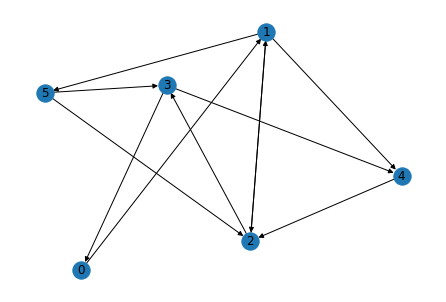

In [132]:
edges = [(0, 1, 2), (1, 2, 2), (1, 4, 1), (1, 5, 3), (2, 1, 2), (2, 3, 4), (3, 0, 1), (3, 4, 2), (4, 2, 3), (5, 2, 3), (5, 3, 2)]
print("Ce graphe n'est pas eulerien :")
print_graph(edges, True)

Voici les chemins ajoutés lors de l'eulerisation : [[2, 1], [4, 2, 1, 5]]


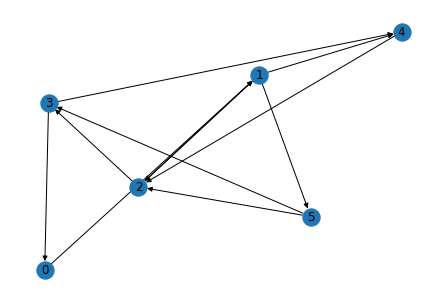

In [133]:
edges = [(0, 1, 2), (1, 2, 2), (1, 4, 1), (1, 5, 3), (2, 1, 2), (2, 3, 4), (3, 0, 1), (3, 4, 2), (4, 2, 3), (5, 2, 3), (5, 3, 2)]
print("Voici les chemins ajoutés lors de l'eulerisation :", eulerization_directed(edges))
print_graph(edges, True)

### Recherche du circuit eulérien

In [134]:
def create_dict_edges(edges):
    res = {}
    i = 0
    lgt = len(edges)

    while (i < lgt):
        cur_v = edges[i][0]
        begin = i
        while (i < lgt and cur_v == edges[i][0]):
            i += 1
        res[cur_v] = [begin, i - begin]
    
    return res


# HIERHOLZER
def eulerian_circuit(edges):
    stack = []
    if (len(edges) > 0):
        stack.append(edges[0][0])
    top = edges[0][0]
    res = []
    dict = create_dict_edges(edges)
    marked_vert = [False for i in range(len(edges))]

    while(len(stack)):
        next = dict[top][0]
        cur_lgt = next + dict[top][1]
        while (next < cur_lgt and marked_vert[next] == True):
            next += 1
        
        if (next < cur_lgt):
            stack.append(edges[next][1])
            top = edges[next][1]
            marked_vert[next] = True
        else:
            res.insert(0, stack.pop())
            if (len(stack)):
                top = stack[len(stack) - 1]
    return res

Circuit eulerien:  [0, 1, 4, 2, 1, 5, 2, 3, 0]


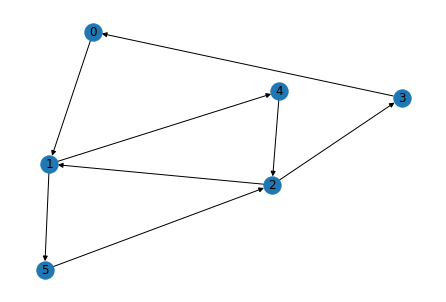

In [135]:
edges = [(0, 1), (1, 4), (1, 5), (2, 1), (2, 3), (3, 0), (4, 2), (5, 2)]
print("Circuit eulerien: ", eulerian_circuit(edges))
print_graph(edges, True)

Circuit eulerien:  [0, 1, 0, 2, 3, 2, 4, 1, 5, 3, 6, 5, 4, 3, 0]


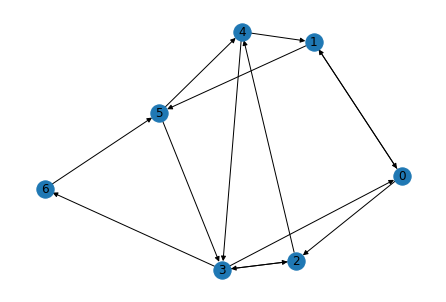

In [136]:
edges = [(0, 1), (0, 2), (1, 0), (1, 5), (2, 3), (2, 4), (3, 0), (3, 2), (3, 6), (4, 1), (4, 3), (5, 3), (5, 4), (6, 5)]
print("Circuit eulerien: ", eulerian_circuit(edges))
print_graph(edges, True)